In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### Carregando o conjunto de dados para regressão.

+ Vamos usar o conjunto de dados habitacional da Califórnia e criar um regressor com uma rede neural.

+ Depois de carregar os dados, dividimos em um conjunto de treinamento, um conjunto de validação e um conjunto de teste, e padronizamos todos os atributos.

In [4]:
# Baixa a base de dados.
housing = fetch_california_housing()

# Divide o conjunto total de exemplos em conjuntos de treinamento e teste.
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)

# Divide o conjunto de treinamento em conjuntos de treinamento (menor) e validação.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Aplica padronização às matrizes de atributos.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Criando e compilando o modelo.

+ Neste exemplo usaremos a API sequencial, mas as `callbacks` também funcionam com a API funcional.

In [5]:
# Define a arquitetura do modelo.
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=[8]),
        keras.layers.Dense(30, activation="relu", name='hidden1'),
        keras.layers.Dense(30, activation="relu", name='hidden2'),
        keras.layers.Dense(1, name='output')
    ]
)

# Define o otimizador.
opt = keras.optimizers.SGD(learning_rate=1e-3)

# Configura o modelo.
model.compile(loss="mse", optimizer=opt)

### Criando a callback `ModelCheckpoint`.

+ A callback `ModelCheckpoint` **salva pontos de verificação do modelo em intervalos regulares** durante o treinamento, por **padrão ao final de cada época**.
    + O parâmetro `save_freq`, pode ser configurado com a string `'epoch'` ou um valor inteiro. Ao usar `'epoch'`, a callback salva o modelo após cada época.
    + Ao usar um valor inteiro, a callback salva o modelo ao final do número de mini-batches especificado.


+ Se usarmos um **conjunto de validação** durante o treinamento, podemos definir o parâmetro `save_best_only=True` ao criar a callback `ModelCheckpoint`.
    + Nesse caso, a callback só salvará o modelo quando seu desempenho no conjunto de validação for o melhor até o momento.


+ Dessa forma, não precisamos nos preocupar em treinar por muito tempo e sobreajustar ao conjunto de treinamento: basta restaurar o último modelo salvo após o treinamento e este será o melhor modelo no conjunto de validação.
    + Precisamos restaurar o modelo manualmente após o treinamento.


+ Esta é uma maneira simples de implementar a parada antecipada (i.e., *early-stop*).
    + Entretanto, o treinamento não é encerrado antecipadamente, ele ocorre até a última época definida.

In [6]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./my_keras_model.keras", save_best_only=True)

### Treinando e avaliando o modelo salvo.

In [7]:
# Treina o modelo com a callback especificada.
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb]
                   )

# Carrega o melhor modelo no conjunto de validação.
model = keras.models.load_model("./my_keras_model.keras")

# Avalia o modelo.
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.2492 - val_loss: 1.1564
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.0439 - val_loss: 0.8112
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7614 - val_loss: 0.6548
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.6788 - val_loss: 0.5830
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6333 - val_loss: 0.5422
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5996 - val_loss: 0.5145
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5726 - val_loss: 0.4942
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5505 - val_loss: 0.4788
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5319 - val_loss: 0.4668
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5160 - val_loss: 0.4578
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4791


### Criando a callback `EarlyStopping`.

+ Outra maneira de implementar a **parada antecipada** é simplesmente usar a callback `EarlyStopping`.


+ **Ela interromperá o treinamento** quando não medir nenhum progresso no conjunto de validação por várias épocas (definidas pelo parâmetro `patience`) e, **opcionalmente, carrega o melhor modelo ao final do treinamento**.
    + Por padrão, a métrica avaliada para encerrar o treinamento é a perda no conjunto de validação.


+ Podemos combinar as duas callbacks para salvar os pontos de verificação do modelo com a `ModelCheckpoint` (no caso de seu computador travar) e interromper o treinamento mais cedo quando não houver mais progresso, com a `EarlyStopping` (para evitar desperdício de tempo e recursos).

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

### Treinando e avaliando o modelo.

+ O número de épocas pode ser definido como um **valor grande**, **pois o treinamento será interrompido automaticamente quando não houver mais progresso**.


+ Além disso, não há necessidade de restaurar o melhor modelo neste caso, pois a callback `EarlyStopping` armazenará os melhores pesos (que resultaram na menor perda de validação) e os restaurará ao final do treinamento quando `restore_best_weights=True`.

In [9]:
# Treina o modelo com as callbacks definidas.
history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb]
                   )

Epoch 1/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5023 - val_loss: 0.4506
Epoch 2/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4903 - val_loss: 0.4445
Epoch 3/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4798 - val_loss: 0.4405
Epoch 4/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4705 - val_loss: 0.4374
Epoch 5/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4624 - val_loss: 0.4344
Epoch 6/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4551 - val_loss: 0.4317
Epoch 7/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4485 - val_loss: 0.4289
Epoch 8/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4426 - val_loss: 0.4258
Epoch 9/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4373 - val_loss: 0.4232
Epoch 10/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4324 - val_loss: 0.4207
Epoch 11/200
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4281 - val_loss: 0.4184
Epoch 12/200
363/363 ━━━━━━━━━━━━━━━━━━━━

### Curvas de aprendizado

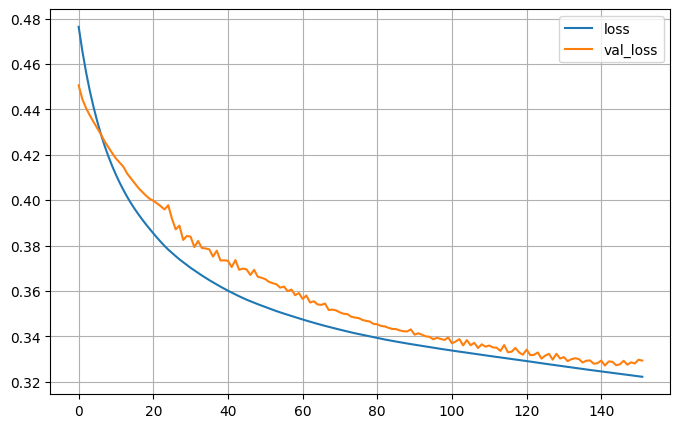

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### O melhor modelo é carregado ao final.

In [14]:
mse_test = model.evaluate(X_test, y_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3290


In [16]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [17]:
for i in range(len(y_pred)):
    print('Actual: %1.3f - Predicted: %1.3f' % (y_test[i], y_pred[i,0]))

Actual: 0.477 - Predicted: 0.570
Actual: 0.458 - Predicted: 1.747
Actual: 5.000 - Predicted: 4.808


### Criando nossa própria callback.

+ Se precisarmos de controle extra, podemos criar facilmente nossas próprias callbacks.


+ Por exemplo, a seguinte callback exibirá a **época** e a **proporção entre a perda de validação e a perda de treinamento** durante o treinamento **ao final de cada época** (por exemplo, para detectarmos overfitting).


+ Notem que a classe `PrintValTrainRatioCallback` **herda** da classe `keras.callbacks.Callback`.


+ Para imprimir a razão entre a perda de validação e a perda de treinamento **ao final de cada época** devemos sobrescrever o método `on_epoch_end` da classe `Callback`.
    + **OBS**.: para que a callback funcione, não podemos alterar a assinatura do método.
    
    
+ O parâmetro `epoch` recebe o número da época corrente e o parâmetro `logs` é um dicionário com informações que incluem as perdas de treinamento e validação.

In [18]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nMinha callback -> epoch: {:d} - val/train: {:.4f}".format(epoch, logs["val_loss"] / logs["loss"]))

### Treinando e avaliando o modelo.

In [19]:
# Instancia objeto da classe PrintValTrainRatioCallback.
val_train_ratio_cb = PrintValTrainRatioCallback()

# Treina o modelo com as callbacks definidas.
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb]
                   )

# O melhor modelo é carregado ao final.
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
344/363 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3362
Minha callback -> epoch: 0 - val/train: 1.0149
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3354 - val_loss: 0.3290
Epoch 2/10
322/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3368
Minha callback -> epoch: 1 - val/train: 1.0152
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3352 - val_loss: 0.3288
Epoch 3/10
329/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3363
Minha callback -> epoch: 2 - val/train: 1.0111
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3350 - val_loss: 0.3273
Epoch 4/10
353/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3351
Minha callback -> epoch: 3 - val/train: 1.0131
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3347 - val_loss: 0.3277
Epoch 5/10
355/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3348
Minha callback -> epoch: 4 - val/train: 1.0185
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3345 - val_loss: 0.3292
Epoch 6/10
361/363 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

### Importante

+ Podemos implementar callbacks para cada um dos seguintes eventos:
    + on_train_begin(),
    + on_train_end(),
    + on_epoch_begin(),
    + on_epoch_begin(),
    + on_batch_end(),
    + on_batch_end().


+ Além disso, caso necessário, as callbacks também podem ser usadas durante a **avaliação** e a **predição**, por exemplo, para depuração. Para isso, devemos implementar alguns métodos.
    + Os métodos abaixo são chamados pelo método **evaluate()**:
        + on_test_begin(),
        + on_test_end(),
        + on_test_batch_begin(),
        + on_test_batch_end().
    + Os métodos abaixo são chamados pelo método **predict()**:
        + on_predict_begin(),
        + on_predict_end(),
        + on_predict_batch_begin(),
        + on_predict_batch_end().